# Making the Required Imports

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
%tensorflow_version 2.5
import keras
from keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.5`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


# Reading the data

In [ ]:
try:
    df = raw.copy()
    print(df.info())
    
except NameError:
    raw = pd.read_pickle("/content/drive/MyDrive/colab_raw/LSWMD.pkl")
    df = raw.copy()
    df.info

In [ ]:
df

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]
...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]


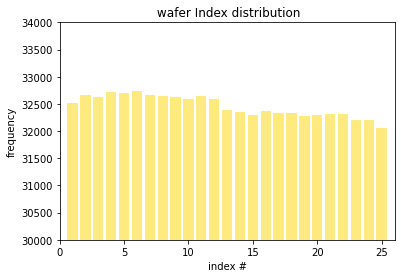

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [ ]:
df = df.drop(['waferIndex'], axis = 1)

In [ ]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1

df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
553682,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",712.0,lot34759,[],[],"(32, 29)"
703733,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",516.0,lot43174,[[Training]],[[none]],"(25, 27)"
53194,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5342.0,lot4314,[],[],"(89, 76)"
781419,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1414.0,lot46322,[[Test]],[[none]],"(42, 44)"
562570,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1,...",710.0,lot35353,[],[],"(32, 29)"


# Preprocessig the data
> Sub wafers with specific resolution.

Now, wafers having (26, 26) resolutionwill be stored in a ndarray and some wafers which has null label have been skip it.

In [ ]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)] #
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [ ]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [ ]:
# check dimension
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


plot 1st data for check.

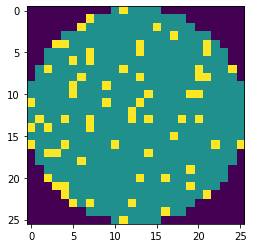

Faulty case : ['none'] 


In [ ]:
# plot 1st data
plt.imshow(x[17])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[17]))

We will use 2D Convolutional Autoencoder, extend dimension for channel.

In [ ]:
#add channel
x = x.reshape((-1, 26, 26, 1))

Make faulty case list, and check how classes imbalanced.

In [ ]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [ ]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [ ]:
#check new x dimension
new_x.shape

(14366, 26, 26, 3)

# Data Augmentation

## Convolutional Autoencoder for Data Augumentation.
As the provided data is very imbalenced we are using data augumentation and in this case, we are using use convolutional autoencoder as the data is consisting of images.

In [ ]:
# parameter
epoch=15
batch_size=1024

In [ ]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

Check summary

In [ ]:
ae.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 26, 26, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 13, 13, 64)       36928     
 ranspose)                                                       
                                                                 
 up_sampling2d_1 (UpSampling  (None, 26, 26, 64)       0         
 2D)                                                             
                                                           

In [ ]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=1)

Epoch 1/15
20/20 [==============================] - 1s 53ms/step - loss: 0.1124
Epoch 2/15
20/20 [==============================] - 1s 41ms/step - loss: 0.0574
Epoch 3/15
20/20 [==============================] - 1s 41ms/step - loss: 0.0433
Epoch 4/15
20/20 [==============================] - 1s 40ms/step - loss: 0.0324
Epoch 5/15
20/20 [==============================] - 1s 41ms/step - loss: 0.0252
Epoch 6/15
20/20 [==============================] - 1s 40ms/step - loss: 0.0202
Epoch 7/15
20/20 [==============================] - 1s 41ms/step - loss: 0.0164
Epoch 8/15
20/20 [==============================] - 1s 41ms/step - loss: 0.0137
Epoch 9/15
20/20 [==============================] - 1s 41ms/step - loss: 0.0119
Epoch 10/15
20/20 [==============================] - 1s 41ms/step - loss: 0.0106
Epoch 11/15
20/20 [==============================] - 1s 41ms/step - loss: 0.0095
Epoch 12/15
20/20 [==============================] - 1s 40ms/step - loss: 0.0088
Epoch 13/15
20/20 [==================

In [ ]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

In [ ]:
# Make decoder model with part of autoencoder model layers
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [ ]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

In [ ]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

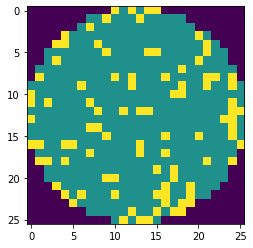

In [ ]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

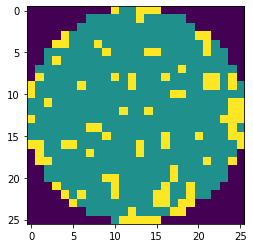

In [ ]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

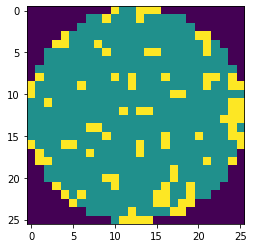

In [ ]:
# check reconstructed original faulty wafer data
gen_x = np.argmax(ae.predict(new_x), axis=3)
plt.imshow(gen_x[3])

## Data augmentation
A Convolutional Autoencoder model for data augmentation providing the final data that has ~2000 samples for each case

In [ ]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [ ]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [ ]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (36925, 26, 26, 3), new_y shape : (47925, 1)


In [ ]:
y[:5]

array([['none'],
       ['none'],
       ['none'],
       ['none'],
       ['none']], dtype='<U9')

In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 4320
Donut : 4004
Edge-Loc : 4736
Edge-Ring : 4092
Loc : 4752
Near-full : 4064
Random : 4292
Scratch : 4176
none : 13489


In [ ]:
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [ ]:
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [ ]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (25925, 26, 26, 3), new_y shape : (36925, 1)


In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 4320
Donut : 4004
Edge-Loc : 4736
Edge-Ring : 4092
Loc : 4752
Near-full : 4064
Random : 4292
Scratch : 4176
none : 2489


In [ ]:
for i, l in enumerate(faulty_case): new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

##Making the model

In [ ]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(
        optimizer='Adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


# Active Learning Module

In [ ]:
# dividing the ndarrays into their fault type divided dictionary
ax_train, ay_train = dict(zip({tuple(row) for row in new_y}, [[],[],[],[],[],[],[],[],[]])), dict(zip({tuple(row) for row in new_y}, [[],[],[],[],[],[],[],[],[]]))

# appending them into the dictionary in the form a tuple as the ndarray is not hashable
for i, e in enumerate(new_y):
    ay_train[tuple(e)].append(e)
    ax_train[tuple(e)].append(new_x[i])

# converting all the values of both the dictionaries back to ndarray form list
for e in ax_train.keys(): ax_train[e] = np.asarray(ax_train[e])
for e in ay_train.keys(): ay_train[e] = np.asarray(ay_train[e])

In [ ]:
# Saving the keys of one-hot encoded faults in a tuple
keys = tuple(ax_train.keys())

In [ ]:
# initialising the validation data variables
test_val_x = []
test_val_y = []

# creating a dictionary for testing with each of the faults divided
ax_test, ay_test = dict(zip({tuple(row) for row in new_y}, [[],[],[],[],[],[],[],[],[]])), dict(zip({tuple(row) for row in new_y}, [[],[],[],[],[],[],[],[],[]]))

# assining last 300 of the faults and removing the same form the train

last = 200

for fault in keys:
    yeet = ax_train[fault][-last:]
    ax_test[tuple(fault)] = np.asarray(yeet)
    test_val_x.extend(yeet)
    ax_train[fault] = ax_train[fault][:-last]

    yeet = ay_train[fault][-last:]
    ay_test[tuple(fault)] = np.asarray(yeet)
    test_val_y.extend(yeet)
    ay_train[fault] = ay_train[fault][:-last]

test_val_x = np.asarray(test_val_x)
test_val_y = np.asarray(test_val_y)

In [ ]:
 from sklearn.model_selection import train_test_split

 val_x, test_x, val_y, test_y = train_test_split(test_val_x, test_val_y, test_size=0.5, random_state=2022)

In [ ]:
maximum_count = max([len(ay_train[e]) for e in keys])

In [ ]:
# The dicitonary which contains the processed data which is sliced based on the need for the increment
adder_index = {e : 0 for e in keys}

# function that increases the required daulty case's data

update_value = 250

def change_index(changes):
    for fault in changes:
        adder_index[fault] += update_value
        # print(adder_index[fault])

    return (
            np.concatenate([ax_train[e][:adder_index[e]] for e in keys]),
            np.concatenate([ay_train[e][:adder_index[e]] for e in keys])
    )

In [ ]:
#This specifies the individual faulty wafer's acceptance for a
# floor value of accuracy
required_individual_score = 95

# This function changes the amount of wafers included for each of the fault
# based on the last iteration of the model.
def class_score(model):
    
    required_changes = []

    for i, e in enumerate(keys):
        
        pred = model.predict(ax_test[e])
        valid = np.argmax(ay_test[e][0], axis=-1)
        
        score = model.score(ax_test[e], ay_test[e])

        if score < required_individual_score/100: required_changes.append(e)

    print("\nThe number of wafers that are need to be updated are {}/9\n\n".format(len(required_changes)))
    return required_changes

In [ ]:
## Function to help reset the parameters

# def flush():
#     print("The Model has been stopped if running and the indexes have been reset to 0")
#     adder_index = {e : 0 for e in keys}
#     current_x, current_y = None, None

In [ ]:
# flush()

In [ ]:
def get_plots(history):
    # accuracy plot 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # loss plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Epoch 1/15
5/5 [==============================] - 5s 583ms/step - loss: 2.8850 - accuracy: 0.1700 - val_loss: 1.8761 - val_accuracy: 0.3544
Epoch 2/15
5/5 [==============================] - 1s 143ms/step - loss: 1.7794 - accuracy: 0.3633 - val_loss: 1.5054 - val_accuracy: 0.4456
Epoch 3/15
5/5 [==============================] - 1s 144ms/step - loss: 1.3054 - accuracy: 0.5591 - val_loss: 1.0332 - val_accuracy: 0.5467
Epoch 4/15
5/5 [==============================] - 1s 144ms/step - loss: 1.0103 - accuracy: 0.5911 - val_loss: 0.8790 - val_accuracy: 0.7078
Epoch 5/15
5/5 [==============================] - 1s 146ms/step - loss: 0.8655 - accuracy: 0.7096 - val_loss: 0.8438 - val_accuracy: 0.6067
Epoch 6/15
5/5 [==============================] - 1s 144ms/step - loss: 0.7010 - accuracy: 0.7462 - val_loss: 0.6277 - val_accuracy: 0.7933
Epoch 7/15
5/5 [==============================] - 1s 144ms/step - loss: 0.5454 - accuracy: 0.8264 - val_loss: 0.5330 - val_accuracy: 0.8178
Epoch 8/15
5/5 [====

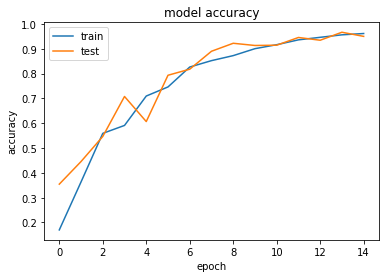

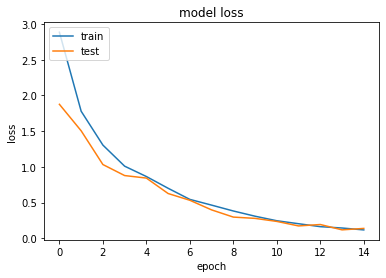

Epoch 1/15
6/6 [==============================] - 2s 222ms/step - loss: 2.6374 - accuracy: 0.1758 - val_loss: 1.7538 - val_accuracy: 0.3589
Epoch 2/15
6/6 [==============================] - 1s 137ms/step - loss: 1.6623 - accuracy: 0.3695 - val_loss: 1.1834 - val_accuracy: 0.6000
Epoch 3/15
6/6 [==============================] - 1s 139ms/step - loss: 1.0558 - accuracy: 0.6196 - val_loss: 0.8364 - val_accuracy: 0.6511
Epoch 4/15
6/6 [==============================] - 1s 138ms/step - loss: 0.7963 - accuracy: 0.7103 - val_loss: 0.6163 - val_accuracy: 0.7644
Epoch 5/15
6/6 [==============================] - 1s 139ms/step - loss: 0.6129 - accuracy: 0.7796 - val_loss: 0.4835 - val_accuracy: 0.8656
Epoch 6/15
6/6 [==============================] - 1s 137ms/step - loss: 0.4583 - accuracy: 0.8531 - val_loss: 0.4173 - val_accuracy: 0.8511
Epoch 7/15
6/6 [==============================] - 1s 139ms/step - loss: 0.3772 - accuracy: 0.8674 - val_loss: 0.2835 - val_accuracy: 0.9278
Epoch 8/15
6/6 [====

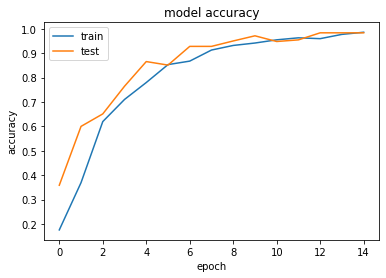

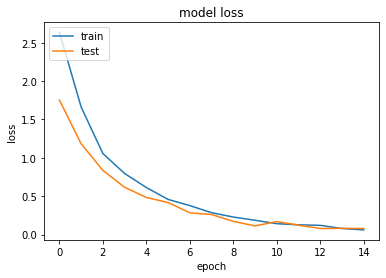

Epoch 1/15
6/6 [==============================] - 3s 420ms/step - loss: 2.7566 - accuracy: 0.2595 - val_loss: 1.5679 - val_accuracy: 0.4122
Epoch 2/15
6/6 [==============================] - 1s 153ms/step - loss: 1.5393 - accuracy: 0.4631 - val_loss: 1.1593 - val_accuracy: 0.6056
Epoch 3/15
6/6 [==============================] - 1s 154ms/step - loss: 1.0060 - accuracy: 0.6381 - val_loss: 0.7847 - val_accuracy: 0.6900
Epoch 4/15
6/6 [==============================] - 1s 154ms/step - loss: 0.8853 - accuracy: 0.7030 - val_loss: 1.3447 - val_accuracy: 0.6467
Epoch 5/15
6/6 [==============================] - 1s 157ms/step - loss: 0.7661 - accuracy: 0.7621 - val_loss: 0.5879 - val_accuracy: 0.7900
Epoch 6/15
6/6 [==============================] - 1s 156ms/step - loss: 0.5441 - accuracy: 0.8219 - val_loss: 0.3862 - val_accuracy: 0.8967
Epoch 7/15
6/6 [==============================] - 1s 156ms/step - loss: 0.4033 - accuracy: 0.8760 - val_loss: 0.2874 - val_accuracy: 0.9089
Epoch 8/15
6/6 [====

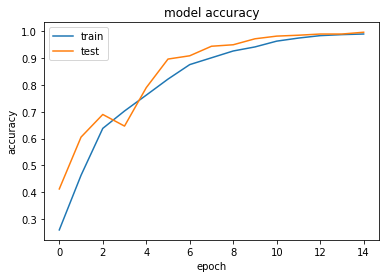

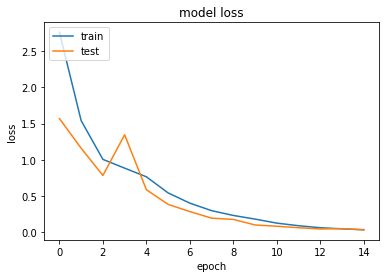

In [ ]:
# The Active Learning Model

epoch = 15
increment = keys[::]
adder_index = {e : 250 for e in keys}

# The amount of wafers that are to be added for the wafer fault whose accuracy
# is below the acceptable level, the deftault assined values is 250

update_value = 250

#The same holds for teh 'required_individual_score' which denotes the amount
# of accuracy that is required for the individal wafer fault type, default value
# is at 95 percent

# required_individual_score = 95

for _ in range(int(sum([len(ax_train[e]) for e in keys])/(update_value*9))):
    try:
        current_x, current_y = change_index(increment)
        history = model.fit(
            current_x,
            current_y,
            validation_data=[val_x, val_y],
            epochs=epoch,
            batch_size=batch_size,
            verbose = 1
        )
        increment = class_score(model)

        get_plots(history)

        if not(increment):
            adder_index = {e : 0 for e in keys}
            break

    except KeyboardInterrupt:
        print("The model has been stopped and the wafer indexes will be set to 0.")
        adder_index = {e : 0 for e in keys}
        break
    

Here there were 3 iterations in the Active Learning Model, making a total of

> (9 x 250) + (3 x 250) + (2 x 250) = 3500

> (9 x 250) + (1 x 250) = 2750

wafers are which are trained out of the available ~12750 which are required for Deep Learning

Test accuracy

In [ ]:
model.score(test_x, test_y)

1/1 - 0s - loss: 0.0396 - accuracy: 0.9878 - 50ms/epoch - 50ms/step


0.9877777695655823

The Accuracy of the model is 0.9877777695655823

# Deep Learning Model


In [ ]:
new_X=new_x[0:19000]
new_Y=new_y[0:19000]
test_x=new_x[19001:19706]
test_y=new_y[19001:19706]
test_x.shape

(705, 26, 26, 3)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(new_X, new_Y, test_size=0.33, random_state=2019)

In [ ]:
# type(x_test)

In [ ]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (12730, 26, 26, 3), y : (12730, 9)
Test x: (6270, 26, 26, 3), y : (6270, 9)


## Simple 2D CNN Model
The data is ready. As wafer data is image. simply use cnn for classification.<br>
### Make model
define create model function, because we will validate model with sklearn kfold cross validation.

In [ ]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

Cross validate model


Using sklearn KFold Cross validation, we validate our simple cnn.

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# # 3-Fold Crossvalidation
# kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
# results = cross_val_score(model, x_train, y_train, cv=kfold)
# # Check 3-fold model's mean accuracy
# print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


In [ ]:
epoch=30
batch_size=1024

In [ ]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=epoch,
         batch_size=batch_size,
         )

Epoch 1/30
13/13 - 7s - loss: 1.9540 - accuracy: 0.3812 - val_loss: 1.1217 - val_accuracy: 0.6212 - 7s/epoch - 572ms/step
Epoch 2/30
13/13 - 5s - loss: 0.8460 - accuracy: 0.7063 - val_loss: 0.4868 - val_accuracy: 0.8458 - 5s/epoch - 373ms/step
Epoch 3/30
13/13 - 5s - loss: 0.3914 - accuracy: 0.8647 - val_loss: 0.2699 - val_accuracy: 0.9225 - 5s/epoch - 373ms/step
Epoch 4/30
13/13 - 5s - loss: 0.2128 - accuracy: 0.9319 - val_loss: 0.1537 - val_accuracy: 0.9545 - 5s/epoch - 372ms/step
Epoch 5/30
13/13 - 5s - loss: 0.1084 - accuracy: 0.9694 - val_loss: 0.1014 - val_accuracy: 0.9652 - 5s/epoch - 374ms/step
Epoch 6/30
13/13 - 5s - loss: 0.0616 - accuracy: 0.9835 - val_loss: 0.0684 - val_accuracy: 0.9777 - 5s/epoch - 373ms/step
Epoch 7/30
13/13 - 5s - loss: 0.0356 - accuracy: 0.9919 - val_loss: 0.0416 - val_accuracy: 0.9872 - 5s/epoch - 375ms/step
Epoch 8/30
13/13 - 5s - loss: 0.0213 - accuracy: 0.9956 - val_loss: 0.0346 - val_accuracy: 0.9885 - 5s/epoch - 373ms/step
Epoch 9/30
13/13 - 5s - 

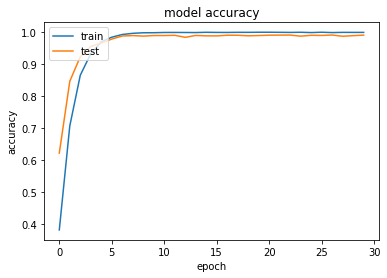

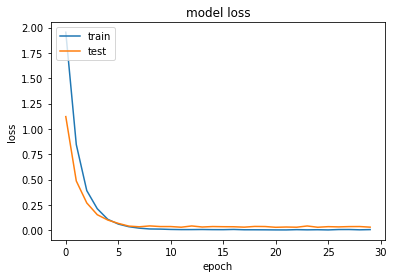

In [ ]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
class_score(model)

1/1 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - 450ms/epoch - 450ms/step
1/1 - 0s - loss: 0.0130 - accuracy: 0.9950 - 92ms/epoch - 92ms/step
1/1 - 0s - loss: 4.8311e-05 - accuracy: 1.0000 - 78ms/epoch - 78ms/step
1/1 - 0s - loss: 0.0418 - accuracy: 0.9950 - 136ms/epoch - 136ms/step
1/1 - 0s - loss: 0.0155 - accuracy: 0.9950 - 72ms/epoch - 72ms/step
1/1 - 0s - loss: 1.0446e-05 - accuracy: 1.0000 - 95ms/epoch - 95ms/step
1/1 - 0s - loss: 0.0099 - accuracy: 1.0000 - 71ms/epoch - 71ms/step
1/1 - 0s - loss: 1.3345e-04 - accuracy: 1.0000 - 60ms/epoch - 60ms/step
1/1 - 0s - loss: 7.7780e-04 - accuracy: 1.0000 - 61ms/epoch - 61ms/step

The number of wafers that are need to be updated are 0/9




[]

In [ ]:
len(x_train)

12730